# Challenge Naïve Bayes Detector

# Physiological Signals Processing 2020-2021

## Biomedical Engineering Degree

### Universidad Rey Juan Carlos


### Authors

#### Eduardo Martínez Mariño, Eloy Pérez Gómez

### Import libraries and modules

We import the libraries and modules we are going to use later in the main code

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import scipy as sc
from scipy import signal as sg
import matplotlib.pyplot as plt
from scipy.signal import hilbert, chirp

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

%matplotlib inline
from scipy.io import loadmat
import matplotlib.pyplot as plt

from IPython.display import display, clear_output

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#https://biosppy.readthedocs.io/en/stable/
#install biosppy

!pip install biosppy

     |████████████████████████████████| 89 kB 1.1 MB/s 


The first thing that we have to consider, before extracting any feature, is that the alarm phase starts at minute 5. This will be really important to extract the different features from the ECG signal (there is no point in getting features of the "healthy" region of a pathological ecg). 

That is why we will process the signal from this point to the end. As we can see in the next block of code, signal 1 (pathological) has a ventricular fibrillation, while signal 4 (healthy) does not present any anormality.

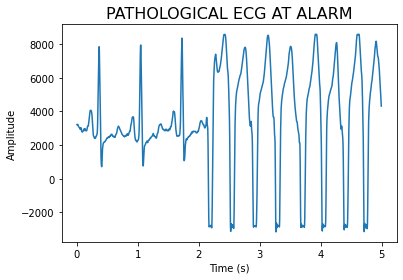

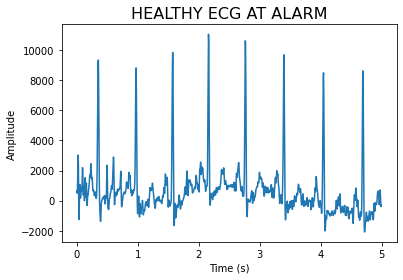

In [2]:
pat_filename_pathological = '1.hea'

signals=[]
for i in range(2):
    path = '/kaggle/input/physiological-signals-processing-challenge-2021/data_challenge/training/'

    pat = loadmat(os.path.join(path,pat_filename_pathological[:-4]+'.mat'))

    #get ECG

    with open(os.path.join(path,pat_filename_pathological)) as f:
            lines = f.readlines()

    #get fs
    fs = int(lines[0].split()[2]) #hz

    #nubmer of signals
    num_signals = int(lines[0].split()[1])
    #get labels
    labels = []
    for signal in lines[1:]:
        #split the string and get the last which is the label
        labels.append(signal.split()[-1])

    #get signals
    signals.append(pat['val'])

    t = np.arange(len(signals[i][0,(5*60-5)*fs:]))/fs
    signal = signals[i][0,(5*60-5)*fs:]
    plt.figure()
    plt.plot(t, signal, label='signal')
    if i == 0:
        plt.title('PATHOLOGICAL ECG AT ALARM', fontsize=16)
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
    else:
        plt.title('HEALTHY ECG AT ALARM', fontsize=16)
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
    pat_filename_pathological = '4.hea'

Another important feature that we will use is the heart rate. To get it, biosspy identifies the r_peaks, as seen in the graph. Then, knowing this peaks, we are able to calculate the heart rate. As we can see in the graph, the r peaks are properly identified in the healthy ECG, but has trouble with the pathological one. This differences in r peaks and consequently in heart rate, will help the bayesian decisor to make a thoughtfull choice.

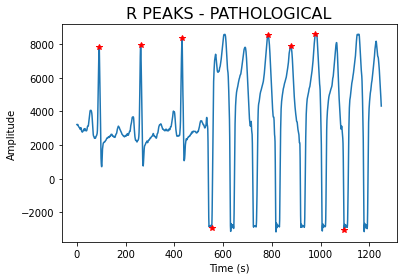

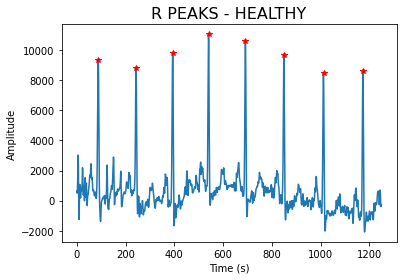

In [3]:
#get the QRS detection
from biosppy.signals.ecg import hamilton_segmenter
from biosppy.signals.ecg import ecg

for i in range(2):
    signalinterval= signals[i][0,(5*60-5)*fs:]
    r_peaks = hamilton_segmenter(signalinterval,sampling_rate = fs)
    r_peaks = r_peaks[0]

    plt.figure()
    if i == 0:
        plt.title('R PEAKS - PATHOLOGICAL', fontsize=16)
    else:
         plt.title('R PEAKS - HEALTHY', fontsize=16)
    
    plt.plot(signalinterval[:])
    plt.plot(r_peaks,signalinterval[r_peaks],'r*')
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    

    #get the rr-interval time series
    r_peaks = hamilton_segmenter(signals[i][0,:],sampling_rate = fs)


Although we didn't use Hamilton at the end, it's pretty useful visually, because, as we can clearly see, the r peaks are not properly distinguished in the pathological signal, which is why we will use the heart rate feature, since it will be distorted in the case of pathological signals.

In this next block of code, we can observe the usage of the function biosppy.signals.ecg.ecg, which, among others, gives us a template of the behavior of the QRS complex, as well as some time lapse before and after it. This is going to be useful to determine wether we have a pathological or healtyh ECG.

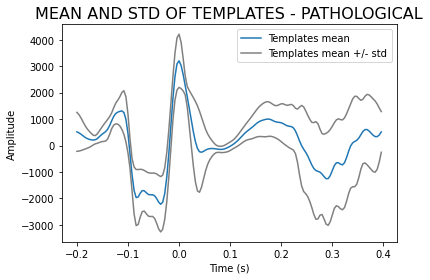

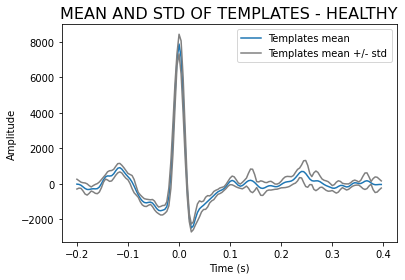

In [4]:
for i in range(2):
    # get complete report
    #we can obtain a complete analysis using ecg function from biosppy
    ts, filte,rpeaks, temp_ts,templates, hr_ts,hr = ecg(signal=signals[i][0,(5*60-5)*fs:], sampling_rate=fs, show=False)

    plt.figure()
    if i == 0:
        plt.title('MEAN AND STD OF TEMPLATES - PATHOLOGICAL', fontsize=16)
    else:
         plt.title('MEAN AND STD OF TEMPLATES - HEALTHY', fontsize=16)
    plt.plot(temp_ts,np.mean(templates,axis = 0), label = "Templates mean")
    plt.plot(temp_ts,np.mean(templates,axis = 0) + np.std(templates,axis = 0),color = [.5,.5,.5], label = "Templates mean +/- std")
    plt.plot(temp_ts,np.mean(templates,axis = 0) - np.std(templates,axis = 0),color = [.5,.5,.5])
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()


Lastly, we are going to make use of the PSD of our signal to obtain the frequency at which the maximum power is reached, which will also give us information of the state of the paritent, as we can see in the next block of code.

Frequency where the max power is at (pathological):  1.4800000000000002
Frequency where the max power is at (healthy):  0.05 



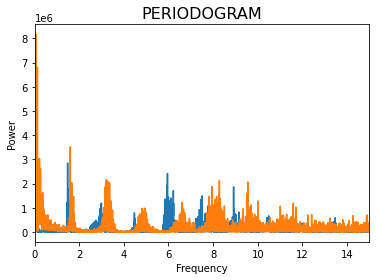

In [5]:
for i in range(2): 
    f, power = sg.periodogram(signals[i][0,:], fs)
    estimated_freq = np.dot(f, power) / sum(f)
    Max = np.amax(power)
    index = np.where(power == Max)
    freq_max = f[index[0][0]]
    if i == 0:
        print("Frequency where the max power is at (pathological): ", freq_max)
    else:
        print("Frequency where the max power is at (healthy): ", freq_max, "\n")


    plt.title('PERIODOGRAM', fontsize=16)
    plt.plot(f, power)
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim([0, 15])
    

# we will come back to this later
signalss = signals

After going through the different features we are going to use, we proceed with the main code.

In [6]:
#get all the possible labels in the training set

for dirname, _, filenames in os.walk('/kaggle/input/physiological-signals-processing-challenge-2021/data_challenge/training/'):
    filenames.sort()
    j = 0
    labels = []
    for filename in filenames:
        if 'mat' in filename:
            continue
        clear_output(wait = True)
        print(j," of ",len(filenames)/2)
        j+=1
        
        with open(os.path.join(dirname,filename)) as f:
                header = f.readlines()
                
        for signal in header[1:]:
    #split the string and get the last which is the label
            labels.append(signal.split()[-1])
        
        

549  of  550.0


In [7]:
print(np.unique(labels))

ecg_lead = ['I', 'II', 'III', 'MCL','V','aVF', 'aVL','aVR']

['ABP' 'I' 'II' 'III' 'MCL' 'PLETH' 'RESP' 'V' 'aVF' 'aVL' 'aVR']


In [8]:
# Main function

def get_mean_std_hr_one_pat(pat,header,plot_flag = True):
    """
    Get the mean heart rate and std of the ECG during the period of alarm, as well as the mean and std of the QRS templates 
    during this same period, the maximum frequency and the difference between the mean hear rate in the alarm period and 
    the first 5 minutes
    
    """

    #Read header and get labels and signals, and from that extract one ECG signal

    #ECG leads in the training set
    ecg_lead = ['I', 'II', 'III', 'MCL','V','aVF', 'aVL','aVR']


    #get fs
    fs = int(header[0].split()[2]) #hz

    #nubmer of signals
    num_signals = int(header[0].split()[1])
    #get labels
    labels = []
    for signal in header[1:]:
    #split the string and get the last which is the label
        labels.append(signal.split()[-1])

    print(labels)

    #get signals
    signals = pat['val']

   #find the ECG signals
    idx_ecg = [labels.index(i) for i in ecg_lead if i in labels]

        
    if plot_flag:
        plt.plot(signals[idx_ecg[0],:1000])
        print(labels[idx_ecg[0]])
        
    
    #handle not enoug beats
    try:
        # preprocessing of the alarm period
        a, b,c, d,templates_alarm, f,hr_alarm = ecg(signal=signals[idx_ecg[0],(5 * 60 - 5)*fs:], sampling_rate=fs, show=False)
        
        # preprocessing of the whole signal for comparison
        a, b,c, d,e, l,hr = ecg(signal=signals[idx_ecg[0],:], sampling_rate=fs, show=False)

        
        f, power = sg.periodogram(signals[idx_ecg[0],(5 * 60 - 5)*fs:], fs)
        
        # get the max frequency
        Max = np.amax(power)
        index = np.where(power == Max)
        
        freq_max = f[index[0][0]]

    except:
        print("Not enough beats")
        print(header[0].split()[0])
        hr = 60
        hr_alarm = 60
        templates_alarm = 900
        freq_max = 0
        
    hr_mean =  np.mean(hr)
    hr_alarm = np.mean(hr_alarm)
    std_alarm = np.std(hr_alarm)
    std_templates_alarm = np.std(templates_alarm)
    mean_templates_alarm = np.mean(templates_alarm)

    # deal with NaN values
    if (np.isnan(hr_mean)):
            print("aqui!")
            hr_mean = 60
    if (np.isnan(std_alarm)):
            print("aqui!")
            std_alarm = 1
    if (np.isnan(hr_alarm)):
            print("aqui!")
            hr_alarm = 90
    if (np.isnan(std_templates_alarm)):
            print("aqui!")
            std_templates_alarm = 800
    if (np.isnan(mean_templates_alarm)):
            print("aqui!")
            mean_templates_alarm = 900
            
    diff_hr = abs(hr_alarm - hr_mean)
    
    if (np.isnan(diff_hr)):
            print("aqui!")
            diff_hr = 0
    
    return hr_alarm, std_alarm, std_templates_alarm, mean_templates_alarm, freq_max, diff_hr
    

550  of  550.0
(550, 7)
[[1.00000000e+00 1.09039858e+02 0.00000000e+00 1.45996555e+03
  1.05760811e+02 2.80000000e+00 1.83266031e+01]
 [1.00000000e+01 1.57787224e+02 0.00000000e+00 1.34112451e+03
  3.95677741e+02 2.80000000e+00 7.98771763e+01]
 [1.00000000e+02 1.28204158e+02 0.00000000e+00 6.52041306e+02
  3.72077129e+00 1.60000000e+00 3.12701346e+01]]


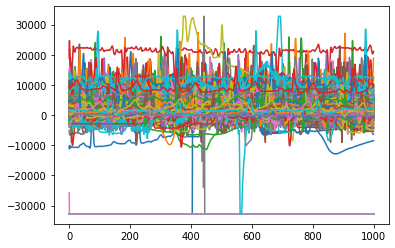

In [9]:
#get into de data folder
from IPython.display import display, clear_output

X = []

for dirname, _, filenames in os.walk('/kaggle/input/physiological-signals-processing-challenge-2021/data_challenge/training/'):
    filenames.sort()
    j = 0
    for filename in filenames[:]:
        #print(filename)
        
        if j%5==0:
            clear_output(wait = True)
            print(j," of ",len(filenames)/2)
            #print(filename)
            
        if 'mat' in filename:
            continue
        #
        #read the pat data
        j+=1
        record = loadmat(os.path.join(dirname,filename[:-4]+'.mat'))
        
        #get the header
        with open(os.path.join(dirname,filename)) as f:
                header = f.readlines()

        #pass to the function to get the mean and std heart rate
        
        hr_alarm, std_alarm, std_templates_alarm, mean_templates_alarm, freq_max, diff_hr = get_mean_std_hr_one_pat(record,header,plot_flag = True)
        
        
        X.append([int(filename[:-4]), hr_alarm, std_alarm, std_templates_alarm, mean_templates_alarm, freq_max, diff_hr])
        
#Matrix X

X = np.array(X)

print(X.shape)
print(X[:3,:])

In [10]:
#Get labels for the patients
y = np.loadtxt('/kaggle/input/physiological-signals-processing-challenge-2021/alarms_training.csv',skiprows=1,delimiter = ',',usecols = [0,1])

print(y.shape)
print(y[:4])


y_train = y[np.array(X[:,0]-1,dtype = int),:]
print(y_train.shape)
#print(y_train[:,0])

#print(X[1,0])
#print(y_train[1,0])

(550, 2)
[[1. 1.]
 [2. 1.]
 [3. 1.]
 [4. 0.]]
(550, 2)


In [11]:
#Create naive bayes
from sklearn.naive_bayes import GaussianNB

#get priors

P_h0 = np.mean(y_train[:,1] == 0)
P_h1 = np.mean(y_train[:,1] == 1)

print('P_h0:',P_h0,'; P_h1:',P_h1)

#naive bayes model

nb_detector = GaussianNB(priors = [P_h0,P_h1])

#train the model
nb_detector.fit(X[:,1:],y_train[:,1])

print("mean values n_classes, n_feauters")
print(nb_detector.theta_)

print("variance values n_classes, n_feauters")
print(nb_detector.sigma_)

P_h0: 0.6145454545454545 ; P_h1: 0.38545454545454544
mean values n_classes, n_feauters
[[9.35738642e+01 8.87573964e-03 1.00547240e+03 1.10861658e+02
  2.90819949e+00 9.75121140e+00]
 [1.20197651e+02 5.66037736e-02 1.07801771e+03 1.22440287e+02
  2.46549865e+00 2.33007971e+01]]
variance values n_classes, n_feauters
[[7.01356648e+02 9.32756837e-03 6.49127029e+05 5.53262740e+04
  1.38585157e+02 1.76077408e+02]
 [1.18550076e+03 5.39303939e-02 3.38412832e+05 1.64471979e+04
  3.39128867e+00 4.45829940e+02]]


Now that we have our parameters obtained we can apply the following rule

$$P(H_1|\boldsymbol{x}) \mathop{\gtrless}^{D_1}_{D_0}P(H_0|\boldsymbol{x})$$

In [12]:
#predict first case

x_1 = X[0,1:]

D = nb_detector.predict(x_1[np.newaxis,:])

print(X[0,0])
print(y_train[0,0])
print('Detection: %d'%D[0])
print('Hypothesis H: %d' %y_train[0,1])

#whole training set
y_hat = nb_detector.predict(X[:,1:])


print('ACC = %.2f'%np.mean(y_hat == y_train[:,1]))

1.0
1.0
Detection: 1
Hypothesis H: 1
ACC = 0.75


Now that we've trained our rule of detection lest try to create a test solution

In [13]:
#  

X_test = []

for dirname, _, filenames in os.walk('/kaggle/input/physiological-signals-processing-challenge-2021/data_challenge/test/'):
    filenames.sort()
    j = 0
    for filename in filenames:
        #print(filename)
        
        if j%25==0:
            clear_output(wait = True)
            print(j," of ",len(filenames)/2)
            #print(filename)
            
        if 'mat' in filename:
            continue
        #
        j+=1
        #read the pat data
        record = loadmat(os.path.join(dirname,filename[:-4]+'.mat'))
        
        #get the header
        with open(os.path.join(dirname,filename)) as f:
                header = f.readlines()

        #pass to the function to get the mean and std heart rate
        
        hr_alarm, std_alarm, std_templates_alarm, mean_templates_alarm, freq_max, diff_hr= get_mean_std_hr_one_pat(record,header,plot_flag = False)
        if (np.isnan(hr_alarm)):
            print("aqui!")
            hr_alarm = 90
        
        X_test.append([int(filename[:-4]), hr_alarm, std_alarm, std_templates_alarm, mean_templates_alarm, freq_max, diff_hr])

200  of  200.0


In [14]:
#sort data
X_test = np.array(X_test)
#print(X_test[:3,:])
idx_sort = np.argsort(X_test[:,0])

X_test = X_test[idx_sort,:]

#print(X_test[:100,:])

np.any(np.isnan(X_test[:,1:]))



False

In [15]:
#predict

y_hat_test = nb_detector.predict(X_test[:,1:])

In [16]:
print(y_hat_test[:])

#create solution

import pandas as pd

df = pd.DataFrame({'Id': X_test[:,0].astype(int), 'Category': y_hat_test.astype(int)})

df.to_csv('submission_naive_bayesfinal3.csv',index = False)

[0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0.
 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1.
 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 1. 1.]


In [17]:
df.head(10)

,Id,Category
0,551,0
1,552,0
2,553,1
3,554,1
4,555,1
5,556,0
6,557,0
7,558,0
8,559,1
9,560,0


## Features that were finally not included

We're going to go briefly over several features we finally didn't implement.

We would also like to say that the comparison between the alarm period and the normal one has a very good potential that we would've also like to exploit, but we couldn't do it due to lack of time.

In [18]:
# Mean power of the periodogram

for i in range(2): 
    f, power = sg.periodogram(signalss[i][0,:], fs)
    if i == 0:
        print("Mean power of the periodogram (pathological): ", np.mean(power))
    else:
        print("Mean power of the periodogram (healthy): ", np.mean(power), "\n")

Mean power of the periodogram (pathological):  10894.232
Mean power of the periodogram (healthy):  30870.107 



We didn't use it because the accuracy was lowered when we included the mean.

Regarding the whole signal, we thought it would be useful to include the QRS templates and their std, but accuracy was also decreased whe we used them. We also didn't find any utility in 

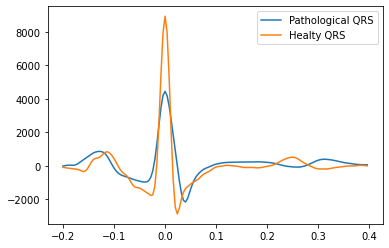

In [19]:
for i in range(2):
    ts, filte,rpeaks, temp_ts,templates, hr_ts,hr = ecg(signal=signals[i][0, :], sampling_rate=fs, show=False)
    if i == 0:
        legend = "Pathological QRS"
    else:
        legend = "Healty QRS"
    plt.plot(temp_ts, np.mean(templates,axis=0), label=legend)
    plt.legend()

# Brief conclusion

In general, we've used the features that increased the accuracy. We tried to use, as already said, the mean of the periodogram and the QRS the template of the whole signal. We also tried to use the envelope of the signal, and the std of the periodogram, without much success. Since we didn't see any significant improvement in the accuracy, we discarded these features.

Even if we had achieved a higher accuracy, we think that this system is not ready yet for medical application. Nevertheless, we think that this is a basic approach that can be greatly improved by using the other signals (ABP and PLETH), focusing more on the difference between the alarm period and the normal period, or using a different decisor, other than the Naïve Bayes.

The features we finally used were:
- The mean and std of the heart rate during the alarm period, as well as the difference in heart rate between the 2 periods (alarm and normal).
- The Frequency with the max power during the alarm period.
- The mean and std of the QRS templates